# Network inference from Brian network

In [63]:
from brian2 import *
%matplotlib inline

In [64]:
def visualise_connectivity(S):
    Ns = len(S.source)
    Nt = len(S.target)
    figure(figsize=(10, 4))
    subplot(121)
    plot(zeros(Ns), arange(Ns), 'ok', ms=10)
    plot(ones(Nt), arange(Nt), 'ok', ms=10)
    for i, j in zip(S.i, S.j):
        plot([0, 1], [i, j], '-k')
    xticks([0, 1], ['Source', 'Target'])
    ylabel('Neuron index')
    xlim(-0.1, 1.1)
    ylim(-1, max(Ns, Nt))
    subplot(122)
    plot(S.i, S.j, 'ok')
    xlim(-1, Ns)
    ylim(-1, Nt)
    xlabel('Source neuron index')
    ylabel('Target neuron index')

### Network

('Number of excitatory neurons:', 7)
('Number of inhibitory neurons:', 3)
(6, 'out of', 10, 'observed. Observed neurons ID:', array([0, 3, 4, 1, 6, 2]))


(-0.5, 5.5, 5.5, -0.5)

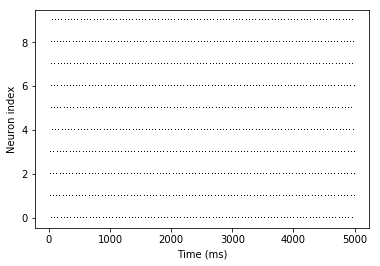

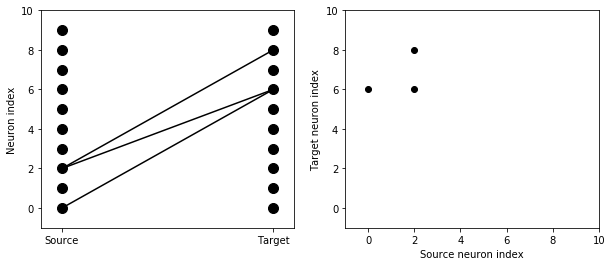

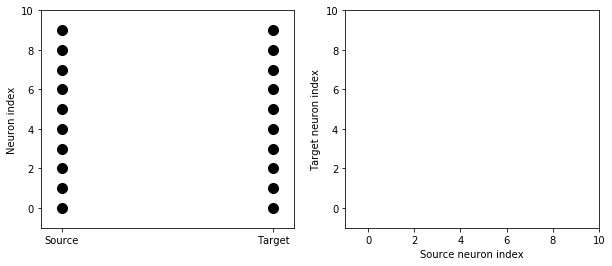

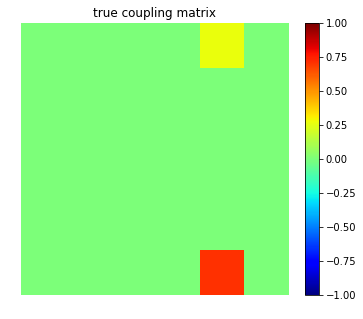

In [65]:
######################
##### PARAMETERS #####
######################

Nneurons_obs = 6  # number of neurons whose spike trains are observed
Nneurons_tot = 10  # number of neurons in total;
N_e = int(0.75*Nneurons_tot) #number of excitatory neurons
N_i = Nneurons_tot - N_e #number of inhibitory neurons

sim_t = 5*second #simulation time

# neuron model parameters:
taum = 20*ms
taue = 5*ms
taui = 10*ms
Vt = -50*mV
Vr = -60*mV
El = -49*mV
T_ref = 5*ms
pe = 0.05 #excitatory connection probability
pi = 0.05 #inhibitory connection probability

# input parameters:
np.random.seed(20)
#mu_vals = -1.75 * (0.8 + 0.4*np.random.rand(Nneurons_tot))  # mV/ms, input mean
#sigma_vals = 2.5 * (0.8 + 0.4*np.random.rand(Nneurons_tot))  # mV/sqrt(ms), input
                                                             # standard deviation

## parameters for data generation:
d = 0.1  # ms, delay
#input_cc = 0.0  # determines the correlation strength of external input fluctuations 
                # for each pair in the network 


print('Number of excitatory neurons:',N_e)
print('Number of inhibitory neurons:',N_i)

######################
###### NETWORK #######
######################

start_scope()

eqs = '''
dv/dt  = (ge+gi-(v-El))/taum : volt (unless refractory)
dge/dt = -ge/taue : volt
dgi/dt = -gi/taui : volt
'''

# neurons
G = NeuronGroup(Nneurons_tot, eqs,method='exact',
                threshold='v>Vt',
                reset='v=Vr',
                refractory=T_ref)

# intial values
G.v = 'Vr + rand() * (Vt - Vr)'
G.ge = 0.0
G.gi = 0.0
#G.mu = mu_vals*mV/ms

# synapses
Se = Synapses(G, G, 'we:volt', on_pre='ge += we')
Si = Synapses(G, G, 'wi:volt', on_pre='gi += wi')
Se.connect('i<=N_e and i!=j',p=pe)
Si.connect('i>N_e and i!=j',p=pi)
Se.we = np.random.rand(len(Se.i))*mV # random excitatory synaptic weight (voltage)
Si.wi = -np.random.rand(len(Si.i))*mV # random inhibitory synaptic weight

# voltage
#statemon = StateMonitor(G,'v',record=True)

# spikes
spikemon = SpikeMonitor(G,record=True)

run(sim_t)

# spiketimes of observed neurons into dictionary for connectivity inference later
obs_neurons_ind = np.random.permutation(Nneurons_tot)[:Nneurons_obs]
print(Nneurons_obs,'out of', Nneurons_tot, 'observed. Observed neurons ID:',obs_neurons_ind)
Spt_dict = {}
for i_N,id_N in enumerate(obs_neurons_ind):
    idx = np.where(spikemon.i == id_N)[0]
    Spt_dict[i_N] = spikemon.t[idx]/ms

## visualize voltage
#figure()
#plot(statemon.t,statemon.v[obs_neurons_ind].T)

# visualize spikes
figure()
plot(spikemon.t/ms,spikemon.i,'k,')
xlabel('Time (ms)')
ylabel('Neuron index')

## visualize connections
visualise_connectivity(Se)
visualise_connectivity(Si)

# visualize weights

Jmat = np.zeros((Nneurons_tot,Nneurons_tot))
for i,j,w in zip(Se.i, Se.j, Se.we):
    Jmat[i,j] = w*10**3
for i,j,w in zip(Se.i, Se.j, Se.we):
    Jmat[i,j] = w*10**3
    
Jmat_obs = Jmat[obs_neurons_ind,:][:,obs_neurons_ind] #connectivity matrix of observed neurons

figure(figsize=(6,5))
subplot(111)
imshow(Jmat_obs, origin='upper', interpolation='nearest', 
           aspect='auto', vmin=-1.0, vmax=1.0, cmap=plt.cm.jet)
title('true coupling matrix')
colorbar()
axis('off')

### Estimation

In [66]:
import multiprocessing
import inference_methods as im

# ESTIMATION PARAMETERS
params = {}
# parameters for estimation (method 1a)
params['tau_m'] = taum/ms
params['pISI_method'] = 'fourier'
f_max = 2000.0 # Hz, determines resolution (accuracy) of ISI density; 
               # 1k seems sufficient in many cases, for finer resolution try 2k or 4k
d_freq = 0.25 # Hz, spacing of frequency grid
d_V = 0.025  # mV, spacing of voltage grid
params['V_s'] = Vt/mV  # mV, spike voltage
params['V_r'] = Vr/mV  # mV, spike voltage
params['tau_m'] = 20.0  # ms, membrane time constant
params['V_T'] = -50.0  # mV, effective threshold voltage (only used for EIF)
params['Delta_T'] = 0.0  # mV, threshold slope factor (set 0 for LIF model, 
                         #                                >0 for EIF model)  
params['T_ref'] = 0.0  # ms, refractory duration
params['V_lb'] = -150.0  # mV, lower bound
params['V_vals'] = np.arange(params['V_lb'],params['V_s']+d_V/2,d_V)
params['freq_vals'] = np.arange(0.0, f_max+d_freq/2, d_freq)/1000  # kHz
params['V_r_idx'] = np.argmin(np.abs(params['V_vals']-params['V_r'])) 
                    # index of reset voltage on grid, this should be a grid point


# parameters for estimation when using the finite volume method instead of the 
# Fourier method to calculate p_ISI^1, which is optional (and often faster)
use_fvm = True  # False: using Fourier method
if use_fvm:
    params['pISI_method'] = 'fvm' 
    d_V = 0.025  # mV, spacing of voltage grid
    params['V_lb'] = -150.0  # mV, lower bound
    params['V_vals'] = np.arange(params['V_lb'],params['V_s']+d_V/2,d_V)
    params['V_r_idx'] = np.argmin(np.abs(params['V_vals']-params['V_r'])) 
                        # index of reset voltage on grid, this should be a grid point
    params['neuron_model'] = 'LIF'
    params['integration_method'] = 'implicit'
    params['N_centers_fvm'] = 1000  # number of centers for voltage discretization
    params['fvm_v_init'] = 'delta'  # voltage density initialization
    params['fvm_delta_peak'] = params['V_r']  # location of initial density peak
    params['fvm_dt'] = 0.1  # ms, time step for finite volume method
                            # 0.1 seems ok, prev. def.: 0.05 ms 

sigma_init = 3.0  # initial sigma value (initial mu value will be determined by 
                  # sigma_init and empirical mean ISI)
N_tpert = 300  # determines spacing of (potential) perturbation times within ISIs
               # due to coupling; def.: 300            
J_bnds = (-3.0, 3.0)  # mV, min./max. coupling strength 
N_procs = int(5.0*multiprocessing.cpu_count()/6)  # number of parallel processes                
             
                
        
# ESTIMATE PARAMETERS from spike trains -----------------------------------
start = time.time()
N = len(Spt_dict.keys())
print(N)
args_fixed = (Spt_dict, d, sigma_init, N_tpert, J_bnds, Jmat, params)
arg_tuple_list = [(iN, N, args_fixed) for iN in range(N)]    
                                                          
print('starting estimation using {} parallel processes'.format(N_procs))
# e.g., one process for each neuron
print('')
print('likelihood optimization can take several minutes...')
pool = multiprocessing.Pool(N_procs)
if use_fvm:
    result = pool.imap_unordered(im.Jij_estim_wrapper_v1, arg_tuple_list)
else:
    result = pool.imap_unordered(im.Jij_estim_wrapper_v2, arg_tuple_list)
#result = map(im.Jij_estim_wrapper_v1, arg_tuple_list)  # single processing
# Jij_estim_wrapper estimates all synaptic strengths for a given 
# post-synaptic neuron (with number iN)

D = {}
obs_neurons_id = list(Spt_dict.keys())
D['J_true'] = Jmat_obs
D['mu_estim'] = np.zeros(N)*np.nan
D['sigma_estim'] = np.zeros(N)*np.nan
D['logl_uncoupled'] = np.zeros(N)*np.nan
D['J_estim'] = np.zeros((N,N))
D['logl_coupled'] = np.zeros((N,N))*np.nan

finished = 0 
for i_N, mu_estim, sigma_estim, logl_uncoupled, \
    J_estim_row, logl_coupled_row in result:
    finished += 1
    print(('{count} of {tot} estimation parts completed').
          format(count=finished, tot=N)) 
    D['mu_estim'][i_N] = mu_estim
    D['sigma_estim'][i_N] = sigma_estim
    D['logl_uncoupled'][i_N] = logl_uncoupled
    D['J_estim'][i_N,:] = J_estim_row
    D['logl_coupled'][i_N,:] = logl_coupled_row

pool.close()
Pcc = np.corrcoef(np.ravel(D['J_estim']),np.ravel(D['J_true']))
print('')
print('estimation took {dur}s, corr.-coeff. = {cc}'.format(
       dur=np.round(time.time() - start,2), cc=Pcc[0,1]) )
print('')
         



6
starting estimation using 3 parallel processes

likelihood optimization can take several minutes...
mean ISI of neuron 1 = 52.9
mean ISI of neuron 2 = 52.9
mean ISI of neuron 3 = 52.9
neuron 2: mu_estim = -2.49, sigma_estim = 0.3
neuron 1: mu_estim = -2.49, sigma_estim = 0.3
neuron 3: mu_estim = -2.49, sigma_estim = 0.3
precalculations for neuron 2 took 19.33s
precalculations for neuron 1 took 19.4s
precalculations for neuron 3 took 19.46s
mean ISI of neuron 4 = 52.9
mean ISI of neuron 5 = 51.54
mean ISI of neuron 6 = 52.9
1 of 6 estimation parts completed
2 of 6 estimation parts completed
3 of 6 estimation parts completed
neuron 5: mu_estim = -2.48, sigma_estim = 0.3
neuron 4: mu_estim = -2.49, sigma_estim = 0.3
neuron 6: mu_estim = -2.49, sigma_estim = 0.3
precalculations for neuron 5 took 14.99s
4 of 6 estimation parts completed
precalculations for neuron 6 took 16.06s
precalculations for neuron 4 took 16.2s
5 of 6 estimation parts completed
6 of 6 estimation parts completed

esti

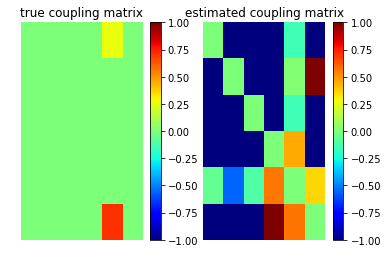

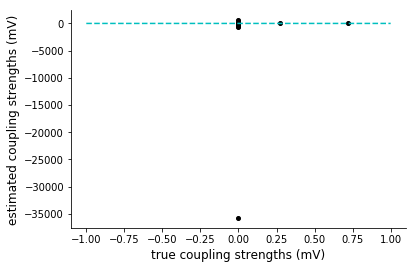

In [67]:
# PLOT --------------------------------------------------------------------
plt.figure()
plt.subplot(121)
plt.imshow(D['J_true'], origin='upper', interpolation='nearest', 
           aspect='auto', vmin=-1.0, vmax=1.0, cmap=plt.cm.jet)
plt.title('true coupling matrix')
plt.colorbar()
plt.axis('off')
plt.subplot(122)
plt.imshow(D['J_estim'], origin='upper', interpolation='nearest', 
           aspect='auto', vmin=-1.0, vmax=1.0, cmap=plt.cm.jet)
plt.title('estimated coupling matrix')
plt.colorbar()
plt.axis('off')

plt.figure()
ax = plt.subplot()
idx = np.diag(np.ones(N))<1
plt.plot(np.ravel(D['J_true'][idx]), np.ravel(D['J_estim'][idx]), 'ok', 
         markersize=4)
plt.plot([-1, 1], [-1, 1], 'c--')
plt.xlabel('true coupling strengths (mV)', fontsize=12)
plt.ylabel('estimated coupling strengths (mV)', fontsize=12)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False) 
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')